### Deeper Look Inside RetinaNet
- What does its anchor boxes look like? 
- What is each helper function doing?
- How to Recover BBox from its output?
- Why rescaling are applied in activ_to_bbox as regularization?

### Notes
- bbox regressor activation indicates offset [off_x, off_y, off_w, off_h]
- **loss function expects target bboxs to be in the form of [center x, center y, w, h]**
- there are helper functions to convert bbox from [off_x, off_y, off_w, off_h] to [center_x, center_y, w, h]
- both ```bbox_to_activ``` and ```activ_to_bbox``` have weighing as regularization (i.e. [0.1, 0.1, 0.2, 0.2])

### Idea
1. visualized Merge Upsampling Layer
2. in training loop, plot the classification activations distribution (whether the improvement comes from less confidence prediction, or more confidence prediction)
3. check out bbox transformation in loss function calculation

### Doubt
1. ```unpad()``` def doesn't make sense
2. given a batch (tensor in torch.float32), how can I decode it back to PILImage with the right RGB?? 
    - ```learn.dls.decode(b[0])```
3. How to sample a fix batch (with randomized augmentation applied)

### Reference
- [fastai nbs dl2 on ReinaNet](https://github.com/fastai/course-v3/blob/master/nbs/dl2/pascal.ipynb)

In [2]:
import os
import sys
path = os.path.join(os.getcwd(), '..')
sys.path.append(path)

from pdb import set_trace
import warnings 
warnings.filterwarnings("ignore")

from fastai2.vision.all import *

from src.data.dblock import build_dblock
from src.data.dls import build_dataloaders
from src.model.model import get_retinanet, split_param_groups
from src.metrics.loss import get_retinanet_loss
from src.metrics.mAP import mAP

%load_ext autoreload
%autoreload 2

In [3]:
data_path = '/userhome/34/h3509807/wheat-data'

In [4]:
dls = build_dataloaders(
    data_path, bs = 8, 
    resize_sz = 256, norm = False, 
    rand_seed = 144, test_mode = True
    )

#### 1a. Encore Boxes: PyTorch Playground

In [5]:
grids = torch.arange(0, 16).long().view(4, 4)
grids

tensor([[ 0,  1,  2,  3],
        [ 4,  5,  6,  7],
        [ 8,  9, 10, 11],
        [12, 13, 14, 15]])

In [6]:
W = 4
torch.linspace(-1+1/W, 1-1/W, W)

tensor([-0.7500, -0.2500,  0.2500,  0.7500])

In [7]:
grid.expand_as??

Object `grid.expand_as` not found.


In [8]:
grid = FloatTensor(4, 4, 2)
v1 = torch.arange(1, 5)
v2 = torch.arange(1, 5)
#torch.ger(v1, v2).expand_as(grid[:, :, 0])
torch.ger(v1, v2)

tensor([[ 1,  2,  3,  4],
        [ 2,  4,  6,  8],
        [ 3,  6,  9, 12],
        [ 4,  8, 12, 16]])

#### 1b. Visualize Simple (Square) Encore Boxes

In [9]:
def create_grid(size):
    """ 
    tensor of grid center expressed in 
    grid.shape = (# GRID, 2) 
    -1: top/ left, +1: bottom/ right
    """
    H, W = size if isinstance(size, tuple) else (size,size)
    grid = FloatTensor(H, W, 2)
    linear_points = torch.linspace(-1+1/W, 1-1/W, W) if W > 1 else tensor([0.])
    grid[:, :, 1] = torch.ger(torch.ones(H), linear_points).expand_as(grid[:, :, 0])
    linear_points = torch.linspace(-1+1/H, 1-1/H, H) if H > 1 else tensor([0.])
    grid[:, :, 0] = torch.ger(linear_points, torch.ones(W)).expand_as(grid[:, :, 1])
    return grid.view(-1,2)

In [10]:
create_grid((2, 3))

tensor([[-0.5000, -0.6667],
        [-0.5000,  0.0000],
        [-0.5000,  0.6667],
        [ 0.5000, -0.6667],
        [ 0.5000,  0.0000],
        [ 0.5000,  0.6667]])

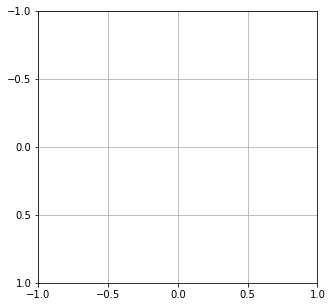

In [11]:
fig, ax = plt.subplots(1, 1, figsize = (5, 5))
ax.set_xticks(np.linspace(-1, 1, 4+1))
ax.set_yticks(np.linspace(-1, 1, 4+1))
ax.set_xlim(-1, 1)
ax.set_ylim(1, -1)
ax.grid()
#ax.set_yticklabels([])
#ax.set_xticklabels([])

In [12]:
def show_anchors(ancs, size):
    _,ax = plt.subplots(1,1, figsize=(8, 8))
    ax.set_xticks(np.linspace(-1, 1, size[1]+1))
    ax.set_yticks(np.linspace(-1, 1, size[0]+1))
    ax.grid()
    ax.scatter(ancs[:,1], ancs[:,0]) #y is first
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_xlim(-1, 1)
    ax.set_ylim(1, -1) #-1 is top, 1 is bottom
    for i, (x, y) in enumerate(zip(ancs[:, 1], ancs[:, 0])): 
        ax.annotate(f'{i}: ({x},{y})', xy = (x-0.15, y-0.1))

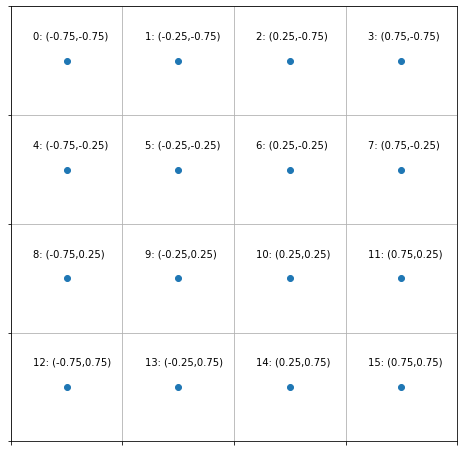

In [13]:
size = (4, 4)
show_anchors(create_grid(size), size)

#### 1c. Visualize Encore Boxes of Varying Ratios, Scales

In [14]:
import matplotlib.cm as cmx
import matplotlib.colors as mcolors
from matplotlib import patches, patheffects
from cycler import cycler

In [15]:
def create_anchors(sizes, ratios, scales, flatten=True):
    "Create anchor of `sizes`, `ratios` and `scales`."
    aspects = [[[s*math.sqrt(r), s*math.sqrt(1/r)] for s in scales] for r in ratios]
    aspects = torch.tensor(aspects).view(-1,2)
    anchors = []
    for h,w in sizes:
        # 4 here to have the anchors overlap.
        sized_aspects = 4 * (aspects * torch.tensor([2/h,2/w])).unsqueeze(0)
        base_grid = create_grid((h,w)).unsqueeze(1)
        n,a = base_grid.size(0),aspects.size(0)
        ancs = torch.cat([base_grid.expand(n,a,2), sized_aspects.expand(n,a,2)], 2)
        anchors.append(ancs.view(h,w,a,4))
    return torch.cat([anc.view(-1,4) for anc in anchors],0) if flatten else anchors

In [16]:
ratios = [1/2,1,2]
scales = [1,2**(-1/3), 2**(-2/3)] 
#Paper used [1,2**(1/3), 2**(2/3)] but a bigger size (600) too, so the largest feature map gave anchors that cover less of the image.
sizes = [(2**i,2**i) for i in range(5)]
sizes.reverse() #Predictions come in the order of the smallest feature map to the biggest
anchors = create_anchors(sizes, ratios, scales)

In [17]:
# there are 5 features map of various sizes 
# for each grid of a features map, it has 9 anchor boxes of different ratios and scales
anchors.size(), sum([(2**i) * (2**i) * 9 for i in range(5)])

(torch.Size([3069, 4]), 3069)

In [18]:
def get_cmap(N):
    color_norm  = mcolors.Normalize(vmin=0, vmax=N-1)
    return cmx.ScalarMappable(norm=color_norm, cmap='Set3').to_rgba

num_color = 12
cmap = get_cmap(num_color)
color_list = [cmap(float(x)) for x in range(num_color)]

In [19]:
def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

def draw_rect(ax, b, color='white'):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor=color, lw=2))
    draw_outline(patch, 4)

def draw_text(ax, xy, txt, sz=14, color='white'):
    text = ax.text(*xy, txt,
        verticalalignment='top', color=color, fontsize=sz, weight='bold')
    draw_outline(text, 1)
    
def show_boxes(boxes):
    "Show the `boxes` (size by 4)"
    _, ax = plt.subplots(1,1, figsize=(5,5))
    ax.set_xlim(-1,1)
    ax.set_ylim(1,-1)
    for i, bbox in enumerate(boxes):
        bb = bbox.numpy()
        rect = [bb[1]-bb[3]/2, bb[0]-bb[2]/2, bb[3], bb[2]]
        draw_rect(ax, rect, color=color_list[i % num_color])
        draw_text(ax, [bb[1]-bb[3]/2,bb[0]-bb[2]/2], str(i), color=color_list[i % num_color])

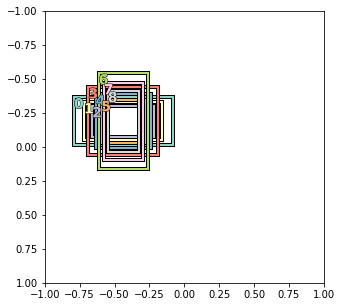

In [20]:
show_boxes(anchors[900:909])

#### 2. Recovering Predicted BBoxes from Model Output
regression subnet output 4 floating points for a predicted bboxes: [p_y, p_x, p_h, p_w]. predicted bboxes can be recovered by:  
- center = [p_y * anc_h + anc_y, p_x * anc_w + anc_x]  
- height = anc_h * exp(p_h)  
- weight = anc_w * exp(p_w)  

if [p_y, p_x, p_h, p_w], predicted bbox is exactly the same as the outstanding anchor box.

In [21]:
def activ_to_bbox(acts, anchors, flatten = True):
    """
    from offset params to [center x, center y, width, height] 
    """
    if flatten:
        # why there is a scaling on activation??
        acts.mul_(acts.new_tensor([[0.1, 0.1, 0.2, 0.2]]))
        centers = anchors[..., 2:] * acts[..., :2] + anchors[..., :2]
        sizes = anchors[..., 2:] * torch.exp(acts[..., :2])
        return torch.cat([centers, sizes], -1)
    else: return [activ_to_bbox(act,anc) for act,anc in zip(acts, anchors)]
    return res

In [22]:
size=(3, 4)
anchors = create_grid(size)
anchors = torch.cat([anchors, torch.tensor([2/size[0],2/size[1]]).expand_as(anchors)], 1)
anchors

tensor([[-0.6667, -0.7500,  0.6667,  0.5000],
        [-0.6667, -0.2500,  0.6667,  0.5000],
        [-0.6667,  0.2500,  0.6667,  0.5000],
        [-0.6667,  0.7500,  0.6667,  0.5000],
        [ 0.0000, -0.7500,  0.6667,  0.5000],
        [ 0.0000, -0.2500,  0.6667,  0.5000],
        [ 0.0000,  0.2500,  0.6667,  0.5000],
        [ 0.0000,  0.7500,  0.6667,  0.5000],
        [ 0.6667, -0.7500,  0.6667,  0.5000],
        [ 0.6667, -0.2500,  0.6667,  0.5000],
        [ 0.6667,  0.2500,  0.6667,  0.5000],
        [ 0.6667,  0.7500,  0.6667,  0.5000]])

In [23]:
activations = torch.randn(size[0] * size[1], 4) * 0.1
bboxes = activ_to_bbox(activations, anchors)
bboxes

tensor([[-6.8098e-01, -7.3879e-01,  6.5250e-01,  5.1134e-01],
        [-6.7579e-01, -2.4489e-01,  6.5760e-01,  5.0513e-01],
        [-6.6156e-01,  2.5724e-01,  6.7179e-01,  5.0729e-01],
        [-6.7540e-01,  7.4713e-01,  6.5799e-01,  4.9714e-01],
        [-8.8013e-03, -7.5205e-01,  6.5792e-01,  4.9796e-01],
        [ 8.8930e-03, -2.5022e-01,  6.7562e-01,  4.9978e-01],
        [-4.8297e-03,  2.5792e-01,  6.6185e-01,  5.0798e-01],
        [-6.4879e-04,  7.5672e-01,  6.6602e-01,  5.0676e-01],
        [ 6.6712e-01, -7.5029e-01,  6.6712e-01,  4.9971e-01],
        [ 6.6726e-01, -2.5402e-01,  6.6726e-01,  4.9599e-01],
        [ 6.7648e-01,  2.4554e-01,  6.7655e-01,  4.9556e-01],
        [ 6.6080e-01,  7.4820e-01,  6.6083e-01,  4.9820e-01]])

In [24]:
def cthw2tlbr(boxes):
    "Convert center/size format `boxes` to top/left bottom/right corners."
    top_left = boxes[:,:2] - boxes[:,2:]/2
    bot_right = boxes[:,:2] + boxes[:,2:]/2
    return torch.cat([top_left, bot_right], 1)

In [25]:
tlbr_bboxes = cthw2tlbr(bboxes)
tlbr_bboxes

tensor([[-1.0072e+00, -9.9446e-01, -3.5473e-01, -4.8312e-01],
        [-1.0046e+00, -4.9746e-01, -3.4699e-01,  7.6749e-03],
        [-9.9746e-01,  3.5920e-03, -3.2567e-01,  5.1088e-01],
        [-1.0044e+00,  4.9856e-01, -3.4641e-01,  9.9570e-01],
        [-3.3776e-01, -1.0010e+00,  3.2016e-01, -5.0307e-01],
        [-3.2892e-01, -5.0011e-01,  3.4670e-01, -3.2847e-04],
        [-3.3576e-01,  3.9282e-03,  3.2610e-01,  5.1191e-01],
        [-3.3366e-01,  5.0334e-01,  3.3236e-01,  1.0101e+00],
        [ 3.3356e-01, -1.0001e+00,  1.0007e+00, -5.0043e-01],
        [ 3.3363e-01, -5.0202e-01,  1.0009e+00, -6.0279e-03],
        [ 3.3820e-01, -2.2392e-03,  1.0147e+00,  4.9332e-01],
        [ 3.3039e-01,  4.9910e-01,  9.9121e-01,  9.9730e-01]])

#### 3. More about RetinaNet Modules

In [26]:
model = get_retinanet()

#### 3a. Classification Subnet
- classification subnet of fastai's RetinaNet doesn't include sigmoid activation function at the end.
- final number of filters is 9 because we have one class (wheat) and 9 different anchor boxes per grid (i.e. 1*9 = 9). Note that unlike YOLO and SSD, background doesn't include as a class so we only have 1 class in this case.

In [27]:
model.classifier

Sequential(
  (0): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (1): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (2): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (3): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (4): Conv2d(256, 9, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

##### 3b. Box Regression Subnet
- Final number of filters are 36 because we have 4 floating outputs for a bounding box, and 9 anchor boxes per grid (i.e. 4*9 = 36).

In [28]:
model.box_regressor

Sequential(
  (0): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (1): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (2): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (3): ConvLayer(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (4): Conv2d(256, 36, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

#### 3c. Try to Visualize LateralUpsampleMerge
visualize how two features 1d map adding together

In [73]:
from src.model.RetinaNet import LateralUpsampleMerge

In [74]:
class DummyHook(Tensor):
    def __init__(self, t):
        self.stored = t

In [88]:
upsample_t = DummyHook(torch.randn(1, 1, 6, 6))
merger = LateralUpsampleMerge(1, 1, upsample_t)
t = torch.randn(1, 1, 3, 3)
out = merger(t)

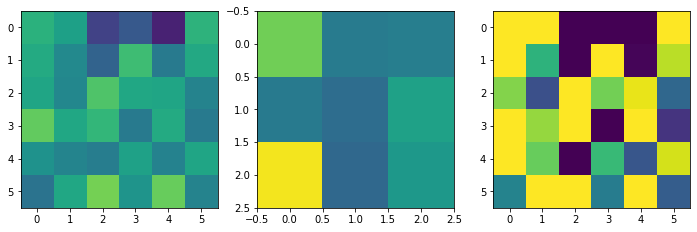

In [89]:
fig, axs = plt.subplots(1, 3, figsize = (12, 6))

axs[0].imshow(upsample_t.cpu().squeeze().numpy(), vmin = -3, vmax = 3)
axs[1].imshow(t.cpu().squeeze().numpy(), vmin = -3, vmax = 3)
axs[2].imshow(out.detach().squeeze().cpu().numpy(), vmin = -3, vmax = 3);

#### 3c. Overall Model Hierarchy

In [29]:
for idx, (name, m) in enumerate(model.named_children()):
    l = len(m) if isinstance(m, nn.Sequential) else 0
    print(f'{idx}: {name} ({l})')

0: encoder (8)
1: c5top5 (0)
2: c5top6 (0)
3: p6top7 (2)
4: merges (0)
5: smoothers (0)
6: classifier (5)
7: box_regressor (5)


#### 4a. Prepare Setup (DataLoaders, Learner, RetinaNet... etc.)

In [161]:
from src.metrics.utils import activ_to_bbox, create_anchors, tlbr2cthw

In [162]:
data_path = Path('/userhome/34/h3509807/wheat-data')
dls = build_dataloaders(data_path, bs = 8, 
                        resize_sz = 256, norm = True, 
                        rand_seed = 144, test_mode = True)

model.cuda()
retinanet_loss = get_retinanet_loss(ratios = None, scales = None)

learn = Learner(dls, model, 
                loss_func = retinanet_loss, 
                splitter = split_param_groups, 
                path = Path('..'))
learn.load('retina_learner')

In [163]:
b = learn.dls.one_batch()

learn.model.eval()
with torch.no_grad():
    output = learn.model(b[0])
type(output), len(output)

(list, 3)

In [164]:
bbox_pred = output[1][5]
sizes = output[2]

scales = learn.loss_func.scales
ratios = learn.loss_func.ratios
anchors = create_anchors(sizes, ratios, scales).to(bbox_pred.device)

bbox_pred.shape, anchors.shape

(torch.Size([46836, 4]), torch.Size([46836, 4]))

#### 4b. Process RetinaNet Outputs

In [165]:
def activ_to_bbox(acts, anchors, flatten = True):
    "Extrapolate bounding boxes on anchors from the model activations."
    if flatten:
        acts.mul_(acts.new_tensor([[0.1, 0.1, 0.2, 0.2]])) #Can't remember where those scales come from, but they help regularize
        centers = anchors[...,2:] * acts[...,:2] + anchors[...,:2]
        sizes = anchors[...,2:] * torch.exp(acts[...,:2])
        return torch.cat([centers, sizes], -1)
    else: return [activ_to_bbox(act,anc) for act,anc in zip(acts, anchors)]
    return res

In [166]:
# from offset to center-wh
cwh_bbox_pred = activ_to_bbox(bbox_pred, anchors)
bbox_pred[:5], cwh_bbox_pred[:5]

(tensor([[ 0.0126,  0.0091,  0.0377, -0.0406],
         [ 0.0052,  0.0088,  0.0611, -0.0374],
         [ 0.0091,  0.0018,  0.0771, -0.0336],
         [ 0.0170,  0.0092, -0.0090, -0.0098],
         [ 0.0116,  0.0118,  0.0144,  0.0033]], device='cuda:0'),
 tensor([[-0.9665, -0.9655,  0.1790,  0.3568],
         [-0.9680, -0.9663,  0.1410,  0.2831],
         [-0.9677, -0.9684,  0.1124,  0.2231],
         [-0.9645, -0.9665,  0.2543,  0.2523],
         [-0.9664, -0.9664,  0.2007,  0.2008]], device='cuda:0'))

In [167]:
def process_output(output, i, detect_thresh=0.25):
    """ 
    Process `output[i]` and return the predicted bboxes above `detect_thresh`.
    
    :return:
        bbox_pred : bbox in normalized cthw format
        scores : confidence score after filtering
        preds : class index for a predicted bbox
    """
    clas_pred,bbox_pred,sizes = output[0][i], output[1][i], output[2]
    anchors = create_anchors(sizes, ratios, scales).to(clas_pred.device)
    bbox_pred = activ_to_bbox(bbox_pred, anchors)
    clas_pred = torch.sigmoid(clas_pred)
    # argmax --> sigmoid(.) --> apply threshold
    detect_mask = clas_pred.max(1)[0] > detect_thresh
    bbox_pred, clas_pred = bbox_pred[detect_mask], clas_pred[detect_mask]
    # still expressed in cthw 
    bbox_pred = tlbr2cthw(torch.clamp(cthw2tlbr(bbox_pred), min=-1, max=1))    
    scores, preds = clas_pred.max(1)
    return bbox_pred, scores, preds

In [168]:
clean_bbox_pred, clean_scores, clean_preds = process_output(output, 5)

In [202]:
clean_bbox_pred

tensor([[-0.9064,  0.1562,  0.1402,  0.2805],
        [-0.9062,  0.1561,  0.1576,  0.1574],
        [-0.9064,  0.2187,  0.1402,  0.2806],
        ...,
        [ 0.9217,  0.1405,  0.1248,  0.1249],
        [ 0.9217,  0.1718,  0.1248,  0.1249],
        [ 0.9217,  0.2030,  0.1248,  0.1249]], device='cuda:0')

#### 4c. Process Batch Input and Target (using ```unpad```)
- why ```unpad``` definition is like this??

In [197]:
def unpad(tgt_bbox, tgt_clas, pad_idx=0):
    i = torch.min(torch.nonzero(tgt_clas-pad_idx))
    return tlbr2cthw(tgt_bbox[i:]), tgt_clas[i:]-1+pad_idx

In [198]:
b = learn.dls.one_batch()
tgt_bbox, tgt_clas = b[1][5], b[2][5]

tgt_bbox.shape, tgt_clas.shape

(torch.Size([35, 4]), torch.Size([35]))

In [199]:
tgt_clas

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')

In [200]:
new_tgt_bbox, new_tgt_clas = unpad(tgt_bbox, tgt_clas, pad_idx = 0)
new_tgt_bbox.shape, new_tgt_clas.shape

(torch.Size([35, 4]), torch.Size([35]))

In [201]:
new_tgt_clas

tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
       device='cuda:0')

#### 4d. Plot Prediction

In [256]:
def intersection(anchors, targets):
    "Compute the sizes of the intersections of `anchors` by `targets`."
    ancs, tgts = cthw2tlbr(anchors), cthw2tlbr(targets)
    a, t = ancs.size(0), tgts.size(0)
    ancs, tgts = ancs.unsqueeze(1).expand(a,t,4), tgts.unsqueeze(0).expand(a,t,4)
    top_left_i = torch.max(ancs[...,:2], tgts[...,:2])
    bot_right_i = torch.min(ancs[...,2:], tgts[...,2:])
    sizes = torch.clamp(bot_right_i - top_left_i, min=0) 
    return sizes[...,0] * sizes[...,1]

def IoU_values(anchors, targets):
    "Compute the IoU values of `anchors` by `targets`."
    inter = intersection(anchors, targets)
    anc_sz, tgt_sz = anchors[:,2] * anchors[:,3], targets[:,2] * targets[:,3]
    union = anc_sz.unsqueeze(1) + tgt_sz.unsqueeze(0) - inter
    return inter/(union+1e-8)

def nms(boxes, scores, thresh=0.3):
    idx_sort = scores.argsort(descending=True)
    boxes, scores = boxes[idx_sort], scores[idx_sort]
    to_keep, indexes = [], torch.LongTensor(range_of(scores))
    while len(scores) > 0:
        to_keep.append(idx_sort[indexes[0]])
        iou_vals = IoU_values(boxes, boxes[:1]).squeeze()
        mask_keep = iou_vals < thresh
        if len(mask_keep.nonzero()) == 0: break
        boxes, scores, indexes = boxes[mask_keep], scores[mask_keep], indexes[mask_keep]
    return LongTensor(to_keep)

In [275]:
import matplotlib.cm as cmx
import matplotlib.colors as mcolors
from cycler import cycler

def _draw_outline(o, lw):
    "Outline bounding box onto image `Patch`."
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

def draw_rect(ax, b, color:str='white', text=None, text_size=14):
    "Draw bounding box on `ax`."
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor=color, lw=2))
    _draw_outline(patch, 4)
    if text is not None:
        patch = ax.text(*b[:2], text, verticalalignment='top', color=color, fontsize=text_size, weight='bold')
        _draw_outline(patch,1)

In [276]:
def show_preds(img, output, idx, detect_thresh=0.25, classes=None, ax=None):
    bbox_pred, scores, preds = process_output(output, idx, detect_thresh)
    if len(scores) != 0:
        to_keep = nms(bbox_pred, scores)
        bbox_pred, preds, scores = bbox_pred[to_keep].cpu(), preds[to_keep].cpu(), scores[to_keep].cpu()
        t_sz = torch.Tensor([*img.size])[None].float()
        bbox_pred[:,:2] = bbox_pred[:,:2] - bbox_pred[:,2:]/2
        bbox_pred[:,:2] = (bbox_pred[:,:2] + 1) * t_sz/2
        bbox_pred[:,2:] = bbox_pred[:,2:] * t_sz
        bbox_pred = bbox_pred.long()
    if ax is None: _, ax = plt.subplots(1,1)
    img.show(ax=ax)
    for bbox, c, scr in zip(bbox_pred, preds, scores):
        txt = str(c.item()) if classes is None else classes[c.item()+1]
        draw_rect(ax, [bbox[1],bbox[0],bbox[3],bbox[2]], text=f'{txt} {scr:.2f}')

In [277]:
b = learn.dls.one_batch()
type(b[0][0])

torch.Tensor

In [278]:
# decode using TfmdList
imgs, bboxs, classes = learn.dls.decode(b)

In [279]:
with torch.no_grad():
    outputs = learn.model(b[0])

img = TensorImage(imgs[0])
img = PILImage.create(img)

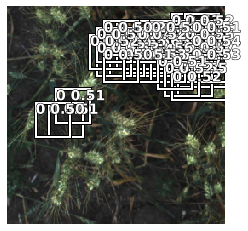

In [288]:
show_preds(img, outputs, 0, detect_thresh = 0.5)